In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import yfinance as yf
from matplotlib import pyplot as plt
from pylab import rcParams
import sklearn
from sklearn.linear_model import LinearRegression
import talib
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import MaxAbsScaler
import time
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.metrics import *
import os
import tensorflow as tf
import tensorflow_addons as tfa 
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
import optuna

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

<h1 style="font-size:40px;"> <center> FUNCTIONS </center> </h1>

In [25]:
SEED = 42


def set_random_seed():
    tf.keras.utils.set_random_seed(
    SEED
)
    

def HMA(df:pd.DataFrame, timeperiod:int= 14) -> float:
    """
    Hull Moving Average.
    Formula:
    HMA = WMA(2*WMA(n/2) - WMA(n)), sqrt(n)
    """
    hma = talib.WMA(2 * talib.WMA(df, int(timeperiod/2)) - talib.WMA(df, timeperiod), int(np.sqrt(timeperiod)))
    return hma


def money_flow_volume_series(df: pd.DataFrame) -> pd.Series:
    """
    Calculates money flow series
    """
    mfv = df['Volume'] * (2*df['Close'] - df['High'] - df['Low']) / \
                                    (df['High'] - df['Low'])
    return mfv


def money_flow_volume(df: pd.DataFrame, timeperiod: int=20) -> pd.Series:
    """
    Calculates money flow volume, or q_t in our formula
    """
    return money_flow_volume_series(df).rolling(timeperiod).sum()


def CMF(df: pd.DataFrame, timeperiod: int=20) -> pd.Series:
    """
    Calculates the Chaikin money flow
    """
    return money_flow_volume(df, timeperiod) / df['Volume'].rolling(timeperiod).sum()


def pltcolor(lst:list) -> list:
    cols=[]
    for i in range(lst.shape[0]):
        if lst.iloc[i] == 1:
            cols.append('green')
        elif lst.iloc[i] == 2:
            cols.append('red')
    return cols
     

def trendNormalizePrices(prices:pd.DataFrame) -> None:
    df = prices.copy()
    df["rowNumber"] = list(range(len(df)))
    df["TN_Open"] = list(range(len(df)))
    df["TN_High"] = list(range(len(df)))
    df["TN_Low"] = list(range(len(df)))
    df["TN_Close"] = list(range(len(df)))
    for i in range(29,len(df)):
        model = LinearRegression()
        model.fit(np.array(df["rowNumber"].iloc[i-29:i+1]).reshape(-1,1), np.array(df["Close"].iloc[i-29:i+1]))
        prediction = model.predict(np.array([df["rowNumber"].iloc[i]]).reshape(-1,1))
        df.iloc[i, df.columns.get_loc("TN_Open")] = df["Open"].iloc[i] - prediction 
        df.iloc[i, df.columns.get_loc("TN_High")] = df["High"].iloc[i] - prediction 
        df.iloc[i, df.columns.get_loc("TN_Low")] = df["Low"].iloc[i] - prediction 
        df.iloc[i, df.columns.get_loc("TN_Close")] = df["Close"].iloc[i] - prediction 
    df["Open"] = df["TN_Open"] 
    df["High"] = df["TN_High"]
    df["Low"] = df["TN_Low"]
    df["Close"] = df["TN_Close"]
    df = df.drop(index=df.index[:30], axis=0)
    df = df.drop(columns=["TN_Open", "TN_High", "TN_Low", "TN_Close", "rowNumber"], axis=1)
    return df
    
    
def create_labels(prices:pd.DataFrame) -> None:
    df = prices.copy()
    df["Label"] = [0] * df.shape[0]
    for i in range(df.shape[0]-10):
        s = set(df["Close"].iloc[i:i+11]) 
        minPrice = sorted(s)[0]
        maxPrice = sorted(s)[-1]
        for j in range(i, i+11):
            if df["Close"].iloc[j] == minPrice and (j-i) == 5:
                df.iloc[j, df.columns.get_loc('Label')] = 1
            elif df["Close"].iloc[j] == maxPrice and (j-i) == 5:
                df.iloc[j, df.columns.get_loc('Label')] = 2
    return df.iloc[6:-6]
                
                
def reverse_one_hot(predictions:np.array) -> np.array:
    return np.argmax(predictions, axis=1)


def one_hot(predictions:np.array) -> np.array:
    predictions_one_hot = []
    for i in predictions:
        prediction = [0,0,0]
        prediction[int(i)] = 1
        predictions_one_hot.append(prediction)   
    return np.array(predictions_one_hot)


def number_null_and_nan(df:pd.DataFrame) -> int:
    na = pd.isna(df).sum().sum()
    null = df.isnull().sum().sum()
    return (na+null) 

<h1 style="font-size:40px;"> <center> DATA PREPROCESSING </center> </h1>

In [4]:
prices = yf.download("SPY", start="2009-09-20", end="2023-01-01", interval="1d", progress=False, auto_adjust=True)
prices

,Open,High,Low,Close,Volume
Date,,,,,
2009-09-21 00:00:00-04:00,82.204712,83.066429,82.026161,82.639450,151892000
2009-09-22 00:00:00-04:00,83.128508,83.353642,82.755871,83.120743,143126700
2009-09-23 00:00:00-04:00,83.314831,83.866019,82.282322,82.429825,225947400
2009-09-24 00:00:00-04:00,82.608374,82.786924,81.164415,81.521523,228636800
2009-09-25 00:00:00-04:00,81.342980,81.793248,80.807316,81.086792,204059000
...,...,...,...,...,...
2022-12-23 00:00:00-05:00,379.649994,383.059998,378.029999,382.910004,59857300
2022-12-27 00:00:00-05:00,382.790009,383.149994,379.649994,381.399994,51638200
2022-12-28 00:00:00-05:00,381.329987,383.390015,376.420013,376.660004,70911500


In [ ]:
plt.figure(figsize=(20,10))
plt.title("SPY Price 2010-2022")
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(prices[["Close"]].iloc[150:,:])

<h1 style="font-size:30px;"> <center> Create Labels and Visualize </center> </h1>

In [11]:
trendNormalizePrices(prices_with_label)

NameError: name 'prices_with_label' is not defined

<h1 style="font-size:30px;"> <center> Adding Technical Indicators </center> </h1>

In [5]:
prices_and_indicators = prices.copy()

In [6]:
for i in range(7,30):
    prices_and_indicators[f"RSI-{i}"] = talib.RSI(prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"WILLR-{i}"] = talib.WILLR(prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"STOCH-{i}"] = talib.STOCH(prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"], fastk_period=i+7, slowk_period=i-4)[0]
    prices_and_indicators[f"STOCHF-{i}"] = talib.STOCHF(prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"], fastk_period=i-2, fastd_period=i-4)[0]
    prices_and_indicators[f"SMA-{i}"] = talib.SMA(prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"EMA-{i}"] = talib.EMA(prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"WMA-{i}"] = talib.WMA(prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"HMA-{i}"] = HMA(prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"TEMA-{i}"] = talib.TEMA(prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"PPO-{i}"] = talib.PPO(prices_and_indicators["Close"], fastperiod=i, slowperiod=i+14)
    prices_and_indicators[f"ROC-{i}"] = talib.ROC(prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"CMO-{i}"] = talib.CMO(prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"MACD-{i}"] = talib.MACD(prices_and_indicators["Close"], fastperiod=i, slowperiod=i+14)[0]
    prices_and_indicators[f"MAMA-{i}"] = talib.MAMA(prices_and_indicators["Close"], fastlimit=1/i, slowlimit=1/(i+14))[0]
    prices_and_indicators[f"STOCHRSI-{i}"] = talib.STOCHRSI(prices_and_indicators["Close"], timeperiod=i)[0]
    prices_and_indicators[f"DX-{i}"] = talib.DX(prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"ADXR-{i}"] = talib.ADXR(prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"CCI-{i}"] = talib.CCI(prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"PLUS_DI-{i}"] = talib.PLUS_DI(prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"MINUS_DI-{i}"] = talib.MINUS_DI(prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"ATR-{i}"] = talib.ATR(prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"SAR-{i}"] = talib.SAR(prices_and_indicators["High"],prices_and_indicators["Low"], maximum = 1/i)
    prices_and_indicators[f"PLUS_DM-{i}"] = talib.PLUS_DM(prices_and_indicators["High"],prices_and_indicators["Low"], timeperiod = i)
    prices_and_indicators[f"AROONOSC-{i}"] = talib.AROONOSC(prices_and_indicators["High"],prices_and_indicators["Low"], timeperiod = i)
    prices_and_indicators[f"MIDPRICE-{i}"] = talib.MIDPRICE(prices_and_indicators["High"],prices_and_indicators["Low"], timeperiod = i)
    prices_and_indicators[f"MFI-{i}"] = talib.MFI(prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"],prices_and_indicators["Volume"], timeperiod = i)
    prices_and_indicators[f"ADOSC-{i}"] = talib.ADOSC(prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"],prices_and_indicators["Volume"], fastperiod=i-4, slowperiod=i+3)
    prices_and_indicators[f"BBANDS-{i}"] = talib.BBANDS(prices_and_indicators["Close"], timeperiod = i)[1]
    prices_and_indicators[f"CMF-{i}"] = CMF(prices_and_indicators, timeperiod = i)
prices_and_indicators["BOP"] = talib.BOP(prices_and_indicators["Open"],prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"])
prices_and_indicators["TRANGE"] = talib.TRANGE(prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"])    
prices_and_indicators["SAREXT"] = talib.SAREXT(prices_and_indicators["High"],prices_and_indicators["Low"])
prices_and_indicators["AD"] = talib.AD(prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"],prices_and_indicators["Volume"])
prices_and_indicators["OBV"] = talib.OBV(prices_and_indicators["Close"],prices_and_indicators["Volume"])
prices_and_indicators.dropna(inplace = True)

C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  del sys.path[0]
C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\ipykernel_launcher.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\ipykernel_launcher.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once us

C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\ipykernel_launcher.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\ipykernel_launcher.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\ipykernel_launcher.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1)

In [7]:
prices_and_indicators

,Open,High,Low,Close,Volume,RSI-7,WILLR-7,STOCH-7,STOCHF-7,SMA-7,EMA-7,WMA-7,HMA-7,TEMA-7,PPO-7,ROC-7,CMO-7,MACD-7,MAMA-7,STOCHRSI-7,DX-7,ADXR-7,CCI-7,PLUS_DI-7,MINUS_DI-7,ATR-7,SAR-7,PLUS_DM-7,AROONOSC-7,MIDPRICE-7,MFI-7,ADOSC-7,BBANDS-7,CMF-7,RSI-8,WILLR-8,STOCH-8,STOCHF-8,SMA-8,EMA-8,WMA-8,HMA-8,TEMA-8,PPO-8,ROC-8,CMO-8,MACD-8,MAMA-8,STOCHRSI-8,DX-8,ADXR-8,CCI-8,PLUS_DI-8,MINUS_DI-8,ATR-8,SAR-8,PLUS_DM-8,AROONOSC-8,MIDPRICE-8,MFI-8,ADOSC-8,BBANDS-8,CMF-8,RSI-9,WILLR-9,STOCH-9,STOCHF-9,SMA-9,EMA-9,WMA-9,HMA-9,TEMA-9,PPO-9,ROC-9,CMO-9,MACD-9,MAMA-9,STOCHRSI-9,DX-9,ADXR-9,CCI-9,PLUS_DI-9,MINUS_DI-9,ATR-9,SAR-9,PLUS_DM-9,AROONOSC-9,MIDPRICE-9,MFI-9,ADOSC-9,BBANDS-9,CMF-9,RSI-10,WILLR-10,STOCH-10,STOCHF-10,SMA-10,EMA-10,WMA-10,HMA-10,TEMA-10,PPO-10,ROC-10,CMO-10,MACD-10,MAMA-10,STOCHRSI-10,DX-10,ADXR-10,CCI-10,PLUS_DI-10,MINUS_DI-10,ATR-10,SAR-10,PLUS_DM-10,AROONOSC-10,MIDPRICE-10,MFI-10,ADOSC-10,BBANDS-10,CMF-10,RSI-11,WILLR-11,STOCH-11,STOCHF-11,SMA-11,EMA-11,WMA-11,HMA-11,TEMA-11,PPO-11,ROC-11,CMO-11,MACD-11,MAMA-11,STOCHRSI-11,DX-11,ADXR-11,CCI-11,PLUS_DI-11,MINUS_DI-11,ATR-11,SAR-11,PLUS_DM-11,AROONOSC-11,MIDPRICE-11,MFI-11,ADOSC-11,BBANDS-11,CMF-11,RSI-12,WILLR-12,STOCH-12,STOCHF-12,SMA-12,EMA-12,WMA-12,HMA-12,TEMA-12,PPO-12,ROC-12,CMO-12,MACD-12,MAMA-12,STOCHRSI-12,DX-12,ADXR-12,CCI-12,PLUS_DI-12,MINUS_DI-12,ATR-12,SAR-12,PLUS_DM-12,AROONOSC-12,MIDPRICE-12,MFI-12,ADOSC-12,BBANDS-12,CMF-12,RSI-13,WILLR-13,STOCH-13,STOCHF-13,SMA-13,EMA-13,WMA-13,HMA-13,TEMA-13,PPO-13,ROC-13,CMO-13,MACD-13,MAMA-13,STOCHRSI-13,DX-13,ADXR-13,CCI-13,PLUS_DI-13,MINUS_DI-13,ATR-13,SAR-13,PLUS_DM-13,AROONOSC-13,MIDPRICE-13,MFI-13,ADOSC-13,BBANDS-13,CMF-13,RSI-14,WILLR-14,STOCH-14,STOCHF-14,SMA-14,EMA-14,WMA-14,HMA-14,TEMA-14,PPO-14,ROC-14,CMO-14,MACD-14,MAMA-14,STOCHRSI-14,DX-14,ADXR-14,CCI-14,PLUS_DI-14,MINUS_DI-14,ATR-14,SAR-14,PLUS_DM-14,AROONOSC-14,MIDPRICE-14,MFI-14,ADOSC-14,BBANDS-14,CMF-14,RSI-15,WILLR-15,STOCH-15,STOCHF-15,SMA-15,EMA-15,WMA-15,HMA-15,TEMA-15,PPO-15,ROC-15,CMO-15,MACD-15,...,ADXR-21,CCI-21,PLUS_DI-21,MINUS_DI-21,ATR-21,SAR-21,PLUS_DM-21,AROONOSC-21,MIDPRICE-21,MFI-21,ADOSC-21,BBANDS-21,CMF-21,RSI-22,WILLR-22,STOCH-22,STOCHF-22,SMA-22,EMA-22,WMA-22,HMA-22,TEMA-22,PPO-22,ROC-22,CMO-22,MACD-22,MAMA-22,STOCHRSI-22,DX-22,ADXR-22,CCI-22,PLUS_DI-22,MINUS_DI-22,ATR-22,SAR-22,PLUS_DM-22,AROONOSC-22,MIDPRICE-22,MFI-22,ADOSC-22,BBANDS-22,CMF-22,RSI-23,WILLR-23,STOCH-23,STOCHF-23,SMA-23,EMA-23,WMA-23,HMA-23,TEMA-23,PPO-23,ROC-23,CMO-23,MACD-23,MAMA-23,STOCHRSI-23,DX-23,ADXR-23,CCI-23,PLUS_DI-23,MINUS_DI-23,ATR-23,SAR-23,PLUS_DM-23,AROONOSC-23,MIDPRICE-23,MFI-23,ADOSC-23,BBANDS-23,CMF-23,RSI-24,WILLR-24,STOCH-24,STOCHF-24,SMA-24,EMA-24,WMA-24,HMA-24,TEMA-24,PPO-24,ROC-24,CMO-24,MACD-24,MAMA-24,STOCHRSI-24,DX-24,ADXR-24,CCI-24,PLUS_DI-24,MINUS_DI-24,ATR-24,SAR-24,PLUS_DM-24,AROONOSC-24,MIDPRICE-24,MFI-24,ADOSC-24,BBANDS-24,CMF-24,RSI-25,WILLR-25,STOCH-25,STOCHF-25,SMA-25,EMA-25,WMA-25,HMA-25,TEMA-25,PPO-25,ROC-25,CMO-25,MACD-25,MAMA-25,STOCHRSI-25,DX-25,ADXR-25,CCI-25,PLUS_DI-25,MINUS_DI-25,ATR-25,SAR-25,PLUS_DM-25,AROONOSC-25,MIDPRICE-25,MFI-25,ADOSC-25,BBANDS-25,CMF-25,RSI-26,WILLR-26,STOCH-26,STOCHF-26,SMA-26,EMA-26,WMA-26,HMA-26,TEMA-26,PPO-26,ROC-26,CMO-26,MACD-26,MAMA-26,STOCHRSI-26,DX-26,ADXR-26,CCI-26,PLUS_DI-26,MINUS_DI-26,ATR-26,SAR-26,PLUS_DM-26,AROONOSC-26,MIDPRICE-26,MFI-26,ADOSC-26,BBANDS-26,CMF-26,RSI-27,WILLR-27,STOCH-27,STOCHF-27,SMA-27,EMA-27,WMA-27,HMA-27,TEMA-27,PPO-27,ROC-27,CMO-27,MACD-27,MAMA-27,STOCHRSI-27,DX-27,ADXR-27,CCI-27,PLUS_DI-27,MINUS_DI-27,ATR-27,SAR-27,PLUS_DM-27,AROONOSC-27,MIDPRICE-27,MFI-27,ADOSC-27,BBANDS-27,CMF-27,RSI-28,WILLR-28,STOCH-28,STOCHF-28,SMA-28,EMA-28,WMA-28,HMA-28,TEMA-28,PPO-28,ROC-28,CMO-28,MACD-28,MAMA-28,STOCHRSI-28,DX-28,ADXR-28,CCI-28,PLUS_DI-28,MINUS_DI-28,ATR-28,SAR-28,PLUS_DM-28,AROONOSC-28,MIDPRICE-28,MFI-28,ADOSC-28,BBANDS-28,CMF-28,RSI-29,WILLR-29,STOCH-29,STOCHF-29,SMA-29,EMA-29,WMA-29,HMA-29,TEMA-29,PPO-29,ROC-29,CMO-29,MACD-29,MAMA-29,STOCHRSI-29,DX-29,ADXR-29,CCI-29,PLUS

<h1 style="font-size:30px;"> <center> Data Labeling </center> </h1>

In [8]:
prices_and_indicators_with_label = create_labels(prices_and_indicators)
prices_and_indicators_with_label

,Open,High,Low,Close,Volume,RSI-7,WILLR-7,STOCH-7,STOCHF-7,SMA-7,EMA-7,WMA-7,HMA-7,TEMA-7,PPO-7,ROC-7,CMO-7,MACD-7,MAMA-7,STOCHRSI-7,DX-7,ADXR-7,CCI-7,PLUS_DI-7,MINUS_DI-7,ATR-7,SAR-7,PLUS_DM-7,AROONOSC-7,MIDPRICE-7,MFI-7,ADOSC-7,BBANDS-7,CMF-7,RSI-8,WILLR-8,STOCH-8,STOCHF-8,SMA-8,EMA-8,WMA-8,HMA-8,TEMA-8,PPO-8,ROC-8,CMO-8,MACD-8,MAMA-8,STOCHRSI-8,DX-8,ADXR-8,CCI-8,PLUS_DI-8,MINUS_DI-8,ATR-8,SAR-8,PLUS_DM-8,AROONOSC-8,MIDPRICE-8,MFI-8,ADOSC-8,BBANDS-8,CMF-8,RSI-9,WILLR-9,STOCH-9,STOCHF-9,SMA-9,EMA-9,WMA-9,HMA-9,TEMA-9,PPO-9,ROC-9,CMO-9,MACD-9,MAMA-9,STOCHRSI-9,DX-9,ADXR-9,CCI-9,PLUS_DI-9,MINUS_DI-9,ATR-9,SAR-9,PLUS_DM-9,AROONOSC-9,MIDPRICE-9,MFI-9,ADOSC-9,BBANDS-9,CMF-9,RSI-10,WILLR-10,STOCH-10,STOCHF-10,SMA-10,EMA-10,WMA-10,HMA-10,TEMA-10,PPO-10,ROC-10,CMO-10,MACD-10,MAMA-10,STOCHRSI-10,DX-10,ADXR-10,CCI-10,PLUS_DI-10,MINUS_DI-10,ATR-10,SAR-10,PLUS_DM-10,AROONOSC-10,MIDPRICE-10,MFI-10,ADOSC-10,BBANDS-10,CMF-10,RSI-11,WILLR-11,STOCH-11,STOCHF-11,SMA-11,EMA-11,WMA-11,HMA-11,TEMA-11,PPO-11,ROC-11,CMO-11,MACD-11,MAMA-11,STOCHRSI-11,DX-11,ADXR-11,CCI-11,PLUS_DI-11,MINUS_DI-11,ATR-11,SAR-11,PLUS_DM-11,AROONOSC-11,MIDPRICE-11,MFI-11,ADOSC-11,BBANDS-11,CMF-11,RSI-12,WILLR-12,STOCH-12,STOCHF-12,SMA-12,EMA-12,WMA-12,HMA-12,TEMA-12,PPO-12,ROC-12,CMO-12,MACD-12,MAMA-12,STOCHRSI-12,DX-12,ADXR-12,CCI-12,PLUS_DI-12,MINUS_DI-12,ATR-12,SAR-12,PLUS_DM-12,AROONOSC-12,MIDPRICE-12,MFI-12,ADOSC-12,BBANDS-12,CMF-12,RSI-13,WILLR-13,STOCH-13,STOCHF-13,SMA-13,EMA-13,WMA-13,HMA-13,TEMA-13,PPO-13,ROC-13,CMO-13,MACD-13,MAMA-13,STOCHRSI-13,DX-13,ADXR-13,CCI-13,PLUS_DI-13,MINUS_DI-13,ATR-13,SAR-13,PLUS_DM-13,AROONOSC-13,MIDPRICE-13,MFI-13,ADOSC-13,BBANDS-13,CMF-13,RSI-14,WILLR-14,STOCH-14,STOCHF-14,SMA-14,EMA-14,WMA-14,HMA-14,TEMA-14,PPO-14,ROC-14,CMO-14,MACD-14,MAMA-14,STOCHRSI-14,DX-14,ADXR-14,CCI-14,PLUS_DI-14,MINUS_DI-14,ATR-14,SAR-14,PLUS_DM-14,AROONOSC-14,MIDPRICE-14,MFI-14,ADOSC-14,BBANDS-14,CMF-14,RSI-15,WILLR-15,STOCH-15,STOCHF-15,SMA-15,EMA-15,WMA-15,HMA-15,TEMA-15,PPO-15,ROC-15,CMO-15,MACD-15,...,CCI-21,PLUS_DI-21,MINUS_DI-21,ATR-21,SAR-21,PLUS_DM-21,AROONOSC-21,MIDPRICE-21,MFI-21,ADOSC-21,BBANDS-21,CMF-21,RSI-22,WILLR-22,STOCH-22,STOCHF-22,SMA-22,EMA-22,WMA-22,HMA-22,TEMA-22,PPO-22,ROC-22,CMO-22,MACD-22,MAMA-22,STOCHRSI-22,DX-22,ADXR-22,CCI-22,PLUS_DI-22,MINUS_DI-22,ATR-22,SAR-22,PLUS_DM-22,AROONOSC-22,MIDPRICE-22,MFI-22,ADOSC-22,BBANDS-22,CMF-22,RSI-23,WILLR-23,STOCH-23,STOCHF-23,SMA-23,EMA-23,WMA-23,HMA-23,TEMA-23,PPO-23,ROC-23,CMO-23,MACD-23,MAMA-23,STOCHRSI-23,DX-23,ADXR-23,CCI-23,PLUS_DI-23,MINUS_DI-23,ATR-23,SAR-23,PLUS_DM-23,AROONOSC-23,MIDPRICE-23,MFI-23,ADOSC-23,BBANDS-23,CMF-23,RSI-24,WILLR-24,STOCH-24,STOCHF-24,SMA-24,EMA-24,WMA-24,HMA-24,TEMA-24,PPO-24,ROC-24,CMO-24,MACD-24,MAMA-24,STOCHRSI-24,DX-24,ADXR-24,CCI-24,PLUS_DI-24,MINUS_DI-24,ATR-24,SAR-24,PLUS_DM-24,AROONOSC-24,MIDPRICE-24,MFI-24,ADOSC-24,BBANDS-24,CMF-24,RSI-25,WILLR-25,STOCH-25,STOCHF-25,SMA-25,EMA-25,WMA-25,HMA-25,TEMA-25,PPO-25,ROC-25,CMO-25,MACD-25,MAMA-25,STOCHRSI-25,DX-25,ADXR-25,CCI-25,PLUS_DI-25,MINUS_DI-25,ATR-25,SAR-25,PLUS_DM-25,AROONOSC-25,MIDPRICE-25,MFI-25,ADOSC-25,BBANDS-25,CMF-25,RSI-26,WILLR-26,STOCH-26,STOCHF-26,SMA-26,EMA-26,WMA-26,HMA-26,TEMA-26,PPO-26,ROC-26,CMO-26,MACD-26,MAMA-26,STOCHRSI-26,DX-26,ADXR-26,CCI-26,PLUS_DI-26,MINUS_DI-26,ATR-26,SAR-26,PLUS_DM-26,AROONOSC-26,MIDPRICE-26,MFI-26,ADOSC-26,BBANDS-26,CMF-26,RSI-27,WILLR-27,STOCH-27,STOCHF-27,SMA-27,EMA-27,WMA-27,HMA-27,TEMA-27,PPO-27,ROC-27,CMO-27,MACD-27,MAMA-27,STOCHRSI-27,DX-27,ADXR-27,CCI-27,PLUS_DI-27,MINUS_DI-27,ATR-27,SAR-27,PLUS_DM-27,AROONOSC-27,MIDPRICE-27,MFI-27,ADOSC-27,BBANDS-27,CMF-27,RSI-28,WILLR-28,STOCH-28,STOCHF-28,SMA-28,EMA-28,WMA-28,HMA-28,TEMA-28,PPO-28,ROC-28,CMO-28,MACD-28,MAMA-28,STOCHRSI-28,DX-28,ADXR-28,CCI-28,PLUS_DI-28,MINUS_DI-28,ATR-28,SAR-28,PLUS_DM-28,AROONOSC-28,MIDPRICE-28,MFI-28,ADOSC-28,BBANDS-28,CMF-28,RSI-29,WILLR-29,STOCH-29,STOCHF-29,SMA-29,EMA-29,WMA-29,HMA-29,TEMA-29,PPO-29,ROC-29,CMO-29,MACD-29,MAMA-29,STOCHRSI-29,DX-29,ADXR-29,CCI-29,PLUS_DI-29,M

In [9]:
prices_and_indicators_with_label["Label"].value_counts()

0    2861
1     196
2     190
Name: Label, dtype: int64

<Figure size 5000x3000 with 0 Axes>

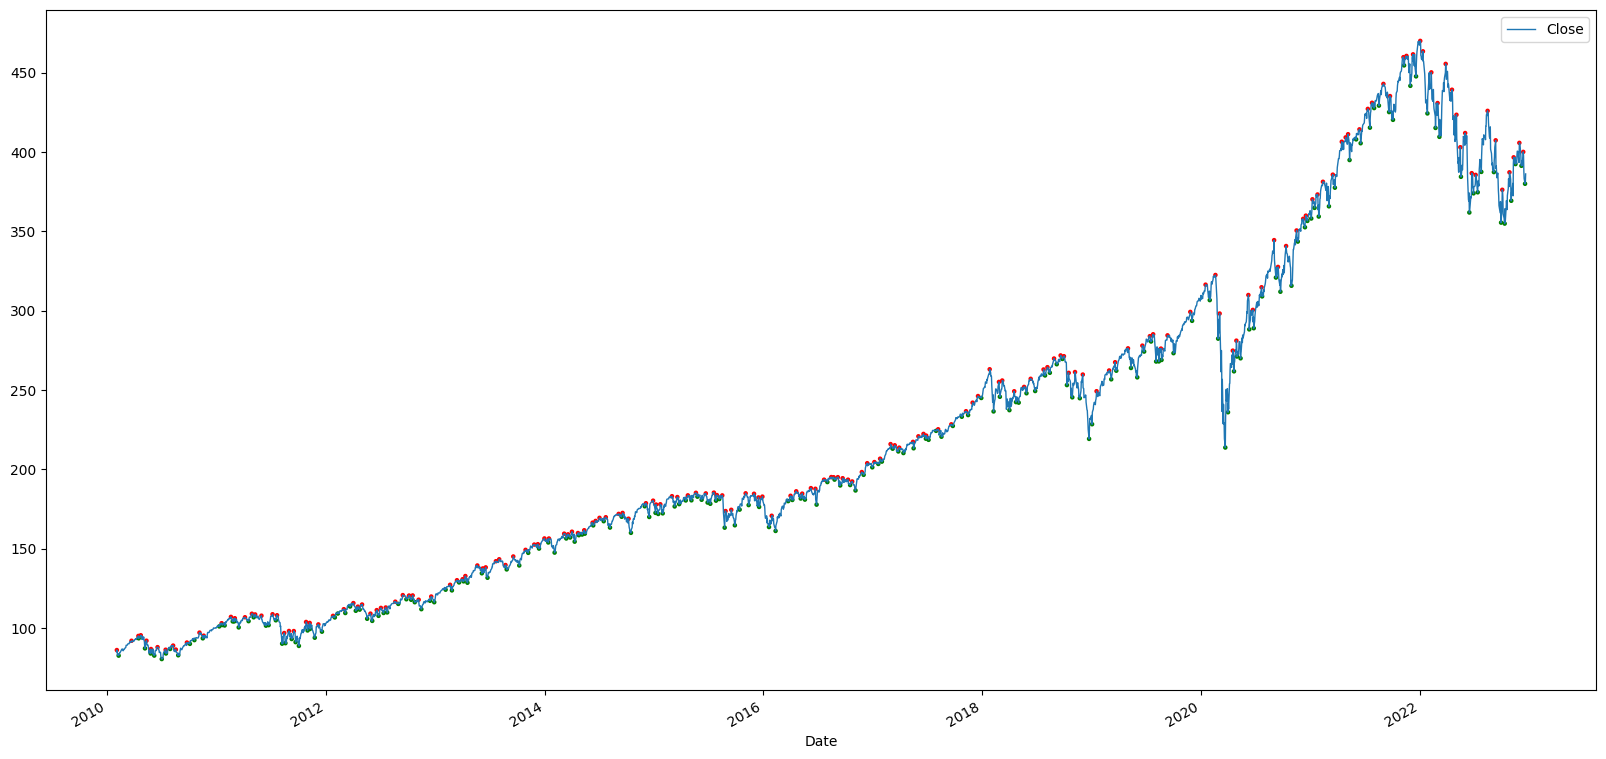

In [10]:
rcParams['figure.figsize'] = 20, 10
plt.figure(figsize=(50, 30))
prices_and_indicators_with_label[["Close"]].plot(kind="line", stacked=False,linewidth=1)
buy_and_sell_preds = prices_and_indicators_with_label.query('Label != 0')
plt.scatter(x = buy_and_sell_preds.index, y = buy_and_sell_preds.Close, s=5, c=pltcolor(buy_and_sell_preds.Label))
plt.show() 

<h1 style="font-size:30px;"> <center> Creating Train & Test Data </center> </h1>

In [11]:
prices_and_indicators_with_label.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3247 entries, 2010-02-01 00:00:00-05:00 to 2022-12-21 00:00:00-05:00
Columns: 678 entries, Open to Label
dtypes: float64(676), int64(2)
memory usage: 16.8 MB


In [12]:
datas = []

for i in range(5, 13):
    train = prices_and_indicators_with_label.loc[ (prices_and_indicators_with_label.index >= f"{2010+i-5}") & (prices_and_indicators_with_label.index <= f"{2010+i}") ]
    test = prices_and_indicators_with_label.loc[ (prices_and_indicators_with_label.index >= f"{2010+i}") & (prices_and_indicators_with_label.index <= f"{2010+i+1}") ]
    datas.append([train, test])

<h1 style="font-size:30px;"> <center> Feature Selection </center> </h1>

In [13]:
for i in range(len(datas)):
    selected_feature_count = 30
    select = SelectKBest(score_func=f_classif, k = selected_feature_count)
    fitted = select.fit(datas[i][0].iloc[:,:-1], datas[i][0].iloc[:,-1])
    train_features = fitted.transform(datas[i][0].iloc[:,:-1])
    test_features = fitted.transform(datas[i][1].iloc[:,:-1])
    
    selected_features_boolean = select.get_support()
    features = list(datas[i][1].columns[:-1])
    selected_features = []
    for j in range(len(features)):
        if selected_features_boolean[j]:
            selected_features.append(features[j])
    train_label = datas[i][0].Label
    test_label = datas[i][1].Label
    
    datas[i][0] = pd.DataFrame(data=train_features.astype('float32'), columns=selected_features, index=datas[i][0].index)
    datas[i][0]["Label"] = train_label
    datas[i][1] = pd.DataFrame(data=test_features.astype('float32'), columns=selected_features, index=datas[i][1].index)
    datas[i][1]["Label"] = test_label

In [14]:
datas[0][0]

,WILLR-7,STOCHF-7,STOCHRSI-7,CCI-7,WILLR-8,STOCHF-8,STOCHRSI-8,STOCHF-9,STOCHRSI-9,STOCHF-10,STOCHRSI-10,STOCHRSI-11,STOCHRSI-12,STOCHRSI-13,STOCHRSI-14,STOCHRSI-15,STOCHRSI-16,STOCHRSI-17,STOCHRSI-18,STOCHRSI-19,STOCHRSI-20,STOCHRSI-21,STOCHRSI-22,STOCHRSI-23,STOCHRSI-24,STOCHRSI-25,STOCHRSI-26,STOCHRSI-27,STOCHRSI-28,STOCHRSI-29,Label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-02-01 00:00:00-05:00,-59.292088,56.615494,100.000000,-76.259163,-73.900566,56.615494,100.000000,40.707912,100.000000,26.099436,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,99.426491,96.800224,94.429039,92.295784,90.346909,88.582748,86.992447,85.517464,84.191864,83.004181,81.929710,80.995476,80.083221,0
2010-02-02 00:00:00-05:00,-6.231459,93.768539,100.000000,86.246437,-30.089226,93.768539,100.000000,93.768539,100.000000,69.910774,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,2
2010-02-03 00:00:00-05:00,-22.550854,77.449142,86.059998,82.488541,-22.550854,77.449142,86.358231,77.449142,86.478699,77.449142,86.486153,86.419739,86.304283,86.156433,85.987320,85.804726,85.614296,85.420692,85.223946,85.027519,84.835030,84.644348,84.459564,84.282867,84.108566,83.944458,83.791397,83.647636,83.519661,83.388191,0
2010-02-04 00:00:00-05:00,-99.520279,0.479721,25.313313,-138.421799,-99.520279,0.479721,24.801374,0.479721,23.799517,0.479721,22.472277,20.929319,19.245718,17.476103,15.658244,13.820128,11.983088,10.166864,8.364157,6.592430,4.870524,3.182353,1.552055,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2010-02-05 00:00:00-05:00,-65.390823,34.609173,9.173903,-147.629318,-65.390823,34.609173,9.075961,34.609173,8.948749,34.609173,8.803659,8.649456,8.492275,8.336339,8.184241,8.037586,7.897314,7.764160,7.637032,7.516468,7.403182,7.295552,7.194628,7.100693,7.011032,6.928230,6.852138,6.781689,6.718923,6.656660,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-24 00:00:00-05:00,-26.825050,55.212620,100.000000,61.015202,-26.825050,72.389305,100.000000,73.174950,100.000000,73.174950,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,0
2014-12-26 00:00:00-05:00,-23.021181,87.345779,100.000000,76.802505,-22.366129,62.657280,100.000000,76.978821,100.000000,77.633873,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,0
2014-12-29 00:00:00-05:00,-34.231518,90.040047,100.000000,96.054237,-21.103176,92.559677,100.000000,65.768478,100.000000,78.896820,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,2


In [15]:
datas[0][1]

,WILLR-7,STOCHF-7,STOCHRSI-7,CCI-7,WILLR-8,STOCHF-8,STOCHRSI-8,STOCHF-9,STOCHRSI-9,STOCHF-10,STOCHRSI-10,STOCHRSI-11,STOCHRSI-12,STOCHRSI-13,STOCHRSI-14,STOCHRSI-15,STOCHRSI-16,STOCHRSI-17,STOCHRSI-18,STOCHRSI-19,STOCHRSI-20,STOCHRSI-21,STOCHRSI-22,STOCHRSI-23,STOCHRSI-24,STOCHRSI-25,STOCHRSI-26,STOCHRSI-27,STOCHRSI-28,STOCHRSI-29,Label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02 00:00:00-05:00,-7.390428e+01,26.095718,0.000000,-149.176788,-7.390428e+01,26.095718,0.000000,26.095718,0.000000,26.095718,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2015-01-05 00:00:00-05:00,-9.514445e+01,4.855553,0.000000,-168.914566,-9.514445e+01,4.855553,0.000000,4.855553,0.000000,4.855553,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2015-01-06 00:00:00-05:00,-9.050445e+01,10.094702,0.000000,-141.480606,-9.050445e+01,9.495548,0.000000,9.495548,0.000000,9.495548,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2015-01-07 00:00:00-05:00,-6.587508e+01,36.977802,71.096336,-69.489143,-6.587508e+01,36.278145,65.546593,34.124916,61.592857,34.124916,58.588032,56.196758,54.230721,52.576626,51.161888,49.937248,48.867527,47.926468,47.093784,46.353329,45.692005,45.098991,44.565247,44.083160,43.646255,43.249008,42.886677,42.555176,42.250977,41.971024,0
2015-01-08 00:00:00-05:00,-2.597288e+01,87.780067,100.000000,31.489706,-3.036663e+01,75.454811,100.000000,74.027122,100.000000,69.633369,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,99.498489,98.898598,98.351753,97.851845,97.393570,2
2015-01-09 00:00:00-05:00,-4.222950e+01,71.296410,78.045815,31.449120,-4.332257e+01,67.207100,77.761147,57.770504,77.430016,56.677425,77.079895,76.723213,76.366776,76.015076,75.671432,75.338364,75.017700,74.710709,74.418152,74.140350,73.877327,73.628815,73.394363,73.173393,72.965248,72.769188,72.584496,72.410423,72.246239,72.091255,0
2015-01-12 00:00:00-05:00,-5.274303e+01,50.132393,58.945229,-13.073111,-5.937841e+01,50.132393,58.263474,47.256973,57.515915,40.621590,56.748432,55.980377,55.221725,54.478973,53.757011,53.059624,52.389618,51.748905,51.138573,50.558998,50.009983,49.490871,49.000671,48.538155,48.101936,47.690536,47.302460,46.936195,46.590282,46.263309,0
2015-01-13 00:00:00-05:00,-5.740748e+01,26.565147,3.517634,-14.999872,-5.985044e+01,42.592522,3.776749,42.592522,3.500282,40.149563,2.917196,2.148417,1.266189,0.318180,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2015-01-14 00:00:00-05:00,-7.082820e+01,29.171795,0.000000,-108.420670,-7.082820e+01,29.171795,0.000000,29.171795,0.000000,29.171795,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


In [16]:
for i in range(len(datas)):
    abs_scaler = MaxAbsScaler()
    abs_scaler.fit(datas[i][0])
    scaled_train = abs_scaler.transform(datas[i][0])
    scaled_test = abs_scaler.transform(datas[i][1])
    datas[i][0] = pd.DataFrame(data=scaled_train, columns=datas[i][0].columns, index=datas[i][0].index)
    datas[i][0]["Label"] = datas[i][0]["Label"] * 2
    datas[i][1] = pd.DataFrame(data=scaled_test, columns=datas[i][1].columns, index=datas[i][1].index)
    datas[i][1]["Label"] = datas[i][1]["Label"] * 2

In [17]:
datas[0][0]

,WILLR-7,STOCHF-7,STOCHRSI-7,CCI-7,WILLR-8,STOCHF-8,STOCHRSI-8,STOCHF-9,STOCHRSI-9,STOCHF-10,STOCHRSI-10,STOCHRSI-11,STOCHRSI-12,STOCHRSI-13,STOCHRSI-14,STOCHRSI-15,STOCHRSI-16,STOCHRSI-17,STOCHRSI-18,STOCHRSI-19,STOCHRSI-20,STOCHRSI-21,STOCHRSI-22,STOCHRSI-23,STOCHRSI-24,STOCHRSI-25,STOCHRSI-26,STOCHRSI-27,STOCHRSI-28,STOCHRSI-29,Label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-02-01 00:00:00-05:00,-0.592921,0.566155,1.000000,-0.326825,-0.739006,0.566155,1.000000,0.407079,1.000000,0.260994,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.994265,0.968002,0.944290,0.922958,0.903469,0.885827,0.869924,0.855175,0.841919,0.830042,0.819297,0.809955,0.800832,0.0
2010-02-02 00:00:00-05:00,-0.062315,0.937685,1.000000,0.369628,-0.300892,0.937685,1.000000,0.937685,1.000000,0.699108,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.0
2010-02-03 00:00:00-05:00,-0.225509,0.774491,0.860600,0.353522,-0.225509,0.774491,0.863582,0.774491,0.864787,0.774491,0.864862,0.864197,0.863043,0.861564,0.859873,0.858047,0.856143,0.854207,0.852239,0.850275,0.848350,0.846443,0.844596,0.842829,0.841086,0.839445,0.837914,0.836476,0.835197,0.833882,0.0
2010-02-04 00:00:00-05:00,-0.995203,0.004797,0.253133,-0.593236,-0.995203,0.004797,0.248014,0.004797,0.237995,0.004797,0.224723,0.209293,0.192457,0.174761,0.156582,0.138201,0.119831,0.101669,0.083642,0.065924,0.048705,0.031824,0.015521,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2010-02-05 00:00:00-05:00,-0.653908,0.346092,0.091739,-0.632697,-0.653908,0.346092,0.090760,0.346092,0.089487,0.346092,0.088037,0.086495,0.084923,0.083363,0.081842,0.080376,0.078973,0.077642,0.076370,0.075165,0.074032,0.072956,0.071946,0.071007,0.070110,0.069282,0.068521,0.067817,0.067189,0.066567,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-24 00:00:00-05:00,-0.268251,0.552126,1.000000,0.261494,-0.268251,0.723893,1.000000,0.731749,1.000000,0.731749,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0
2014-12-26 00:00:00-05:00,-0.230212,0.873458,1.000000,0.329154,-0.223661,0.626573,1.000000,0.769788,1.000000,0.776339,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0
2014-12-29 00:00:00-05:00,-0.342315,0.900400,1.000000,0.411661,-0.211032,0.925597,1.000000,0.657685,1.000000,0.788968,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.0


In [18]:
datas[0][1]

,WILLR-7,STOCHF-7,STOCHRSI-7,CCI-7,WILLR-8,STOCHF-8,STOCHRSI-8,STOCHF-9,STOCHRSI-9,STOCHF-10,STOCHRSI-10,STOCHRSI-11,STOCHRSI-12,STOCHRSI-13,STOCHRSI-14,STOCHRSI-15,STOCHRSI-16,STOCHRSI-17,STOCHRSI-18,STOCHRSI-19,STOCHRSI-20,STOCHRSI-21,STOCHRSI-22,STOCHRSI-23,STOCHRSI-24,STOCHRSI-25,STOCHRSI-26,STOCHRSI-27,STOCHRSI-28,STOCHRSI-29,Label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02 00:00:00-05:00,-7.390428e-01,0.260957,0.000000,-0.639329,-7.390428e-01,0.260957,0.000000,0.260957,0.000000,0.260957,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2015-01-05 00:00:00-05:00,-9.514445e-01,0.048556,0.000000,-0.723920,-9.514445e-01,0.048556,0.000000,0.048556,0.000000,0.048556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2015-01-06 00:00:00-05:00,-9.050445e-01,0.100947,0.000000,-0.606345,-9.050445e-01,0.094955,0.000000,0.094955,0.000000,0.094955,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
2015-01-07 00:00:00-05:00,-6.587508e-01,0.369778,0.710963,-0.297811,-6.587508e-01,0.362781,0.655466,0.341249,0.615929,0.341249,0.585880,0.561968,0.542307,0.525766,0.511619,0.499372,0.488675,0.479265,0.470938,0.463533,0.456920,0.450990,0.445652,0.440832,0.436463,0.432490,0.428867,0.425552,0.422510,0.419710,0.0
2015-01-08 00:00:00-05:00,-2.597288e-01,0.877801,1.000000,0.134956,-3.036663e-01,0.754548,1.000000,0.740271,1.000000,0.696334,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.994985,0.988986,0.983518,0.978518,0.973936,2.0
2015-01-09 00:00:00-05:00,-4.222950e-01,0.712964,0.780458,0.134782,-4.332257e-01,0.672071,0.777611,0.577705,0.774300,0.566774,0.770799,0.767232,0.763668,0.760151,0.756714,0.753384,0.750177,0.747107,0.744182,0.741404,0.738773,0.736288,0.733944,0.731734,0.729652,0.727692,0.725845,0.724104,0.722462,0.720913,0.0
2015-01-12 00:00:00-05:00,-5.274303e-01,0.501324,0.589452,-0.056028,-5.937841e-01,0.501324,0.582635,0.472570,0.575159,0.406216,0.567484,0.559804,0.552217,0.544790,0.537570,0.530596,0.523896,0.517489,0.511386,0.505590,0.500100,0.494909,0.490007,0.485382,0.481019,0.476905,0.473025,0.469362,0.465903,0.462633,0.0
2015-01-13 00:00:00-05:00,-5.740748e-01,0.265651,0.035176,-0.064285,-5.985044e-01,0.425925,0.037767,0.425925,0.035003,0.401496,0.029172,0.021484,0.012662,0.003182,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2015-01-14 00:00:00-05:00,-7.082820e-01,0.291718,0.000000,-0.464660,-7.082820e-01,0.291718,0.000000,0.291718,0.000000,0.291718,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


<h1 style="font-size:30px;"> <center> Controling Null Values </center> </h1>

In [19]:
total_na_count = 0
for data in datas:
    total_na_count += number_null_and_nan(data[0])
    total_na_count += number_null_and_nan(data[1])
print(f"Total null and nan values = {total_na_count}")

Total null and nan values = 0


<h1 style="font-size:40px;"> <center> MODEL INITIALIZATIONS </center> </h1>

<h1 style="font-size:30px;"> <center> MLP </center> </h1>

In [20]:
def create_model_MLP(trial=None, activation_func="swish", dropout_rate = 0.2, optimizer_algo = "adam"):
    MLP = Sequential()
    MLP.add(Dense(64, input_shape=(30,), activation=activation_func, kernel_initializer=tf.keras.initializers.HeUniform()))
    MLP.add(BatchNormalization())
    MLP.add(Dense(32, activation=activation_func))
    MLP.add(Dropout(dropout_rate))
    MLP.add(Dense(32, activation=activation_func))
    MLP.add(Dropout(dropout_rate))
    MLP.add(Dense(3, activation='softmax'))
    MLP.compile(loss="categorical_crossentropy", optimizer=optimizer_algo, metrics=["accuracy","Precision","Recall","AUC",tfa.metrics.F1Score(num_classes=3, average="macro")])
    return MLP

In [22]:
set_random_seed()

start_time = time.time()
predictions = []
f1_scores = []

for i in range(len(datas)):
    OUTPUT_PATH = "./outputs"
    es = EarlyStopping(monitor='val_f1_score', mode='max', verbose=1, patience=20, min_delta=1e-2)
    mcp = ModelCheckpoint(os.path.join(OUTPUT_PATH,f"best_CNN_model-{i+1}.h5"), monitor='val_f1_score', verbose=0, 
                          save_best_only=True, save_weights_only=False, mode='max')
    
    val_split_point = int(0.5*len(datas[i][0]))
    X_train = datas[i][0][:val_split_point].iloc[:, :-1]
    y_train = tf.keras.utils.to_categorical(datas[i][0][:val_split_point].iloc[:, -1], num_classes = 3)
    X_val = datas[i][0][val_split_point:].iloc[:, :-1]
    y_val = tf.keras.utils.to_categorical(datas[i][0][val_split_point:].iloc[:, -1], num_classes = 3)
    X_test = datas[i][1].iloc[:, :-1]
    y_test = datas[i][1].iloc[:, -1]
    
    model = create_model_MLP()
    model.fit(X_train, y_train, batch_size=64, 
                        epochs=1, verbose=0, callbacks=[es, mcp], 
                        validation_data=(X_val, y_val), 
                        class_weight={0:1, 1:10, 2:10})
    y_pred = model.predict(X_test)
    y_pred = y_pred.argmax(axis=-1)
    predictions.append(y_pred)
    f1_scores.append(f1_score(y_test, y_pred, average='macro'))
    
print(f"\nAverage f1-macro score: {np.mean(f1_scores)}\n")
minutes = round(int(time.time() - start_time)/60, 2)
print(f"\nCompleted in {minutes} minutes\n")

8/8 [==============================] - 0s 4ms/step

Average f1-macro score: 0.23430051914693795


Completed in 0.42 minutes



<h1 style="font-size:30px;"> <center> LSTM </center> </h1>

<h1 style="font-size:30px;"> <center> GRU </center> </h1>

<h1 style="font-size:30px;"> <center> CNN </center> </h1>

<h1 style="font-size:40px;"> <center> HYPERPARAMETER TUNING </center> </h1>

<h1 style="font-size:30px;"> <center> MLP </center> </h1>

In [28]:
set_random_seed()
start_time = time.time()

def objective(trial):
    activation_func = trial.suggest_categorical(name="activation_func", choices = ["relu", "selu", "swish"])
    dropout_rate = trial.suggest_categorical("drop_out_rate", [0.1, 0.2, 0.3])
    optimizer_algo = trial.suggest_categorical("optimizer_algorithm", ["adam", "adadelta", "rmsprop"])
    batch = trial.suggest_categorical("batch_size", [32, 64, 256])
    #epoch_num = trial.suggest_categorical("epoch_number", [50, 100, 200])
    lr_max = trial.suggest_categorical("learning_rate_max", [1e-1,1e-2,1e-3,1e-4])

    model = create_model_MLP(trial, activation_func, dropout_rate, optimizer_algo)

    f1_scores = []

    for i in range(len(datas)):
        OUTPUT_PATH = "./outputs"
        es = EarlyStopping(monitor='f1_score', mode='max', verbose=1, patience=20, min_delta=1e-2)
        mcp = ModelCheckpoint(os.path.join(OUTPUT_PATH,f"best_CNN_model-{i+1}.h5"), monitor='f1_score', verbose=0, 
                                  save_best_only=True, save_weights_only=False, mode='max')

        val_split_point = int(0.5*len(datas[i][0]))
        X_train = datas[i][0][:val_split_point].iloc[:, :-1]
        y_train = tf.keras.utils.to_categorical(datas[i][0][:val_split_point].iloc[:, -1], num_classes = 3)
        X_val = datas[i][0][val_split_point:].iloc[:, :-1]
        y_val = datas[i][0][val_split_point:].iloc[:, -1]

        model.fit(X_train, y_train, batch_size=batch, 
                                epochs=1, verbose=0, callbacks=[es, mcp], 
                                class_weight={0:1, 1:10, 2:10})
        y_pred = model.predict(X_val)
        y_pred = y_pred.argmax(axis=-1)
        f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    return np.mean(f1_scores)

study = optuna.create_study(study_name="MLP_Bayesian_Optimization", direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(objective, n_trials=5)
trial = study.best_trial

print("\n------------------------------------------")
print('Best F1 Macro: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))
minutes = round(int(time.time() - start_time)/60, 2)
print(f"\nCompleted in {minutes} minutes")

[I 2023-01-23 09:57:26,785] A new study created in memory with name: MLP_Bayesian_Optimization


20/20 [==============================] - 0s 3ms/step


[I 2023-01-23 09:57:31,342] Trial 0 finished with value: 0.15288016161891205 and parameters: {'activation_func': 'selu', 'drop_out_rate': 0.1, 'optimizer_algorithm': 'adadelta', 'batch_size': 256, 'learning_rate_max': 0.1}. Best is trial 0 with value: 0.15288016161891205.


20/20 [==============================] - 0s 2ms/step


[I 2023-01-23 09:57:35,881] Trial 1 finished with value: 0.372206628350575 and parameters: {'activation_func': 'selu', 'drop_out_rate': 0.2, 'optimizer_algorithm': 'rmsprop', 'batch_size': 32, 'learning_rate_max': 0.001}. Best is trial 1 with value: 0.372206628350575.


20/20 [==============================] - 0s 2ms/step


[I 2023-01-23 09:57:40,672] Trial 2 finished with value: 0.30545068838941025 and parameters: {'activation_func': 'swish', 'drop_out_rate': 0.1, 'optimizer_algorithm': 'adam', 'batch_size': 256, 'learning_rate_max': 0.01}. Best is trial 1 with value: 0.372206628350575.


20/20 [==============================] - 0s 3ms/step


[I 2023-01-23 09:57:45,791] Trial 3 finished with value: 0.0689181994822591 and parameters: {'activation_func': 'swish', 'drop_out_rate': 0.2, 'optimizer_algorithm': 'adadelta', 'batch_size': 256, 'learning_rate_max': 0.001}. Best is trial 1 with value: 0.372206628350575.


20/20 [==============================] - 0s 3ms/step


[I 2023-01-23 09:57:50,614] Trial 4 finished with value: 0.4285032751552301 and parameters: {'activation_func': 'selu', 'drop_out_rate': 0.3, 'optimizer_algorithm': 'adam', 'batch_size': 32, 'learning_rate_max': 0.1}. Best is trial 4 with value: 0.4285032751552301.



------------------------------------------
Best F1 Macro: 0.4285032751552301
Best hyperparameters: {'activation_func': 'selu', 'drop_out_rate': 0.3, 'optimizer_algorithm': 'adam', 'batch_size': 32, 'learning_rate_max': 0.1}

Completed in 0.38 minutes


<h1 style="font-size:30px;"> <center> LSTM </center> </h1>

<h1 style="font-size:30px;"> <center> GRU </center> </h1>

<h1 style="font-size:30px;"> <center> CNN </center> </h1>

<h1 style="font-size:40px;"> <center> FINANCIAL EVALUATION </center> </h1>

<h1 style="font-size:30px;"> <center> MLP </center> </h1>

<h1 style="font-size:30px;"> <center> LSTM </center> </h1>

<h1 style="font-size:30px;"> <center> GRU </center> </h1>

<h1 style="font-size:30px;"> <center> CNN </center> </h1>